# MMPose预训练模型预测-Python API

同济子豪兄 2023-4-1

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test/multi-person.jpeg'

In [5]:
# Image.open(img_path)

## 构建目标检测模型（任选一个运行）

In [6]:
# Faster R CNN
detector = init_detector(
    'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [7]:
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

## 构建人体姿态估计模型

In [7]:
pose_estimator = init_pose_estimator(
    'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [8]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

05/18 09:30:08 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [9]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [10]:
detect_result.keys()

['ignored_instances', 'pred_instances', 'gt_instances']

In [11]:
# 预测类别
detect_result.pred_instances.labels

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0, 58,  0,  0, 58,  0,  0,  2,
         0,  0,  2,  0,  0,  0,  0, 24,  2, 58, 26, 26,  0,  0, 58,  0, 26,  0,
        27, 24,  0, 26, 26, 26, 26, 26, 58,  0, 26, 26, 26,  2, 32,  2, 58, 39,
         2,  0, 58, 24, 58, 32, 24, 26,  0,  0,  2, 37,  0, 39,  9, 74,  0,  2,
        58, 24,  0,  0, 26, 29], device='cuda:0')

In [12]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9994, 0.9988, 0.9974, 0.9963, 0.9959, 0.9930, 0.9914, 0.9901, 0.9868,
        0.9824, 0.9631, 0.9271, 0.9080, 0.8950, 0.8793, 0.8582, 0.8250, 0.8188,
        0.7240, 0.7184, 0.7056, 0.6656, 0.6204, 0.6008, 0.6002, 0.5708, 0.5652,
        0.5060, 0.4550, 0.4090, 0.3945, 0.3905, 0.3534, 0.3105, 0.3041, 0.2595,
        0.2292, 0.2222, 0.2155, 0.1886, 0.1866, 0.1847, 0.1794, 0.1774, 0.1716,
        0.1673, 0.1396, 0.1390, 0.1389, 0.1371, 0.1343, 0.1249, 0.1203, 0.1155,
        0.1130, 0.1121, 0.1011, 0.1008, 0.0939, 0.0925, 0.0919, 0.0916, 0.0885,
        0.0820, 0.0806, 0.0727, 0.0697, 0.0686, 0.0676, 0.0631, 0.0627, 0.0624,
        0.0588, 0.0580, 0.0558, 0.0536, 0.0510, 0.0501], device='cuda:0')

In [15]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [16]:
# 置信度阈值
CONF_THRES = 0.5

In [17]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [18]:
bboxes

array([[1705.6367  ,   96.27122 , 2114.5154  , 1301.1788  ],
       [1267.5951  ,   94.706314, 1701.0658  , 1316.31    ],
       [ 720.3761  ,  172.254   , 1152.6993  , 1267.8214  ],
       [   7.275108,  238.24524 ,  171.00726 , 1140.8091  ],
       [1063.195   ,  219.20604 , 1348.993   , 1244.7435  ],
       [ 436.2358  ,  428.57394 ,  586.09186 ,  911.88464 ],
       [ 109.99206 ,  212.12    ,  324.6581  , 1122.9656  ],
       [2079.33    ,  478.2343  , 2224.411   ,  925.20807 ],
       [ 543.71326 ,  406.4836  ,  650.8414  ,  919.4548  ],
       [2363.2969  ,  501.85876 , 2455.2212  ,  857.2465  ],
       [2308.2085  ,  561.45154 , 2372.7485  ,  715.7704  ],
       [1990.6097  ,  485.10776 , 2105.6323  ,  923.4378  ],
       [2255.5212  ,  568.44495 , 2326.8691  ,  702.4414  ],
       [ 830.37805 ,  297.20706 ,  897.0452  ,  349.59396 ],
       [ 704.988   ,  419.5749  ,  808.70483 ,  989.6047  ],
       [1646.6781  ,  484.4088  , 1787.3289  ,  936.5005  ],
       [2437.259   ,  59

## 预测-关键点

In [19]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

05/18 09:30:37 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [20]:
len(pose_results)

18

In [21]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [22]:
data_samples.keys()

['pred_instances', '_pred_heatmaps', 'pred_fields', 'gt_instances']

## 预测结果-关键点坐标

In [23]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(18, 17, 2)

In [24]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[1915.95938746,  186.87463284],
       [1927.72606277,  175.10795689],
       [1892.42603683,  175.10795689],
       [1963.02608871,  198.64130878],
       [1857.12601089,  186.87463284],
       [2010.09278997,  316.30806828],
       [1810.05930964,  328.07474422],
       [2092.45951716,  492.80820751],
       [1786.52595901,  445.74150372],
       [1986.55943934,  410.44147587],
       [1762.99260839,  504.57488346],
       [1963.02608871,  657.5416708 ],
       [1821.82598495,  645.77499485],
       [1939.49273809,  939.94189358],
       [1821.82598495,  904.64186573],
       [1927.72606277, 1116.44203281],
       [1857.12601089, 1187.04208851]])

## 预测结果-关键点热力图

In [25]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 1418, 2520)

In [26]:
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [27]:
heatmap.shape

(1418, 2520)

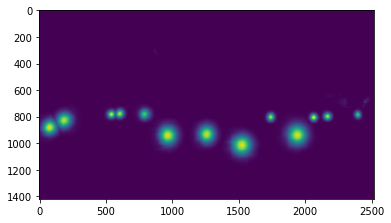

In [28]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [29]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

05/18 09:32:04 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [30]:
# 元数据
# pose_estimator.dataset_meta

## 展示可视化效果

In [31]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [32]:
img_output.shape

(2836, 2520, 3)

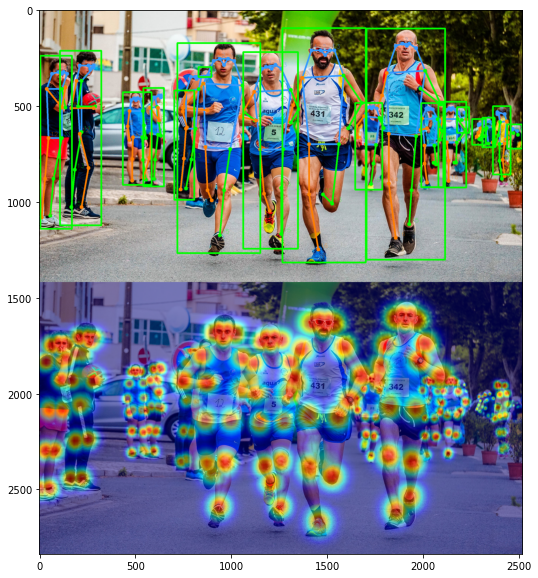

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()